## SSD 的实现

- 因为在目标检测中，每个锚框都会被看作是一个样本，在SSD中，有很多尺寸的特征图会被用作预测，对于一张图来说会有很多的锚框，对于每个锚框，都要预测$num_classes + 1$个类，那么就会面临参数过多的问题，在这里借鉴了NiN的思路，使用卷积层做预测，降低模型的复杂度

In [19]:
%matplotlib inline
import torch
from torch import nn
import torchvision
from torch.nn import functional as F
from d2l import torch as d2l

# 类别预测器
def cls_predictor(num_inputs, num_anchors, num_classes):
    # 输入[c, h, w]每个像素点都有num_anchors个锚框，每个锚框要预测num_classes + 1个类
    # 所以输出num_anchors * (num_classes + 1)个通道，代表每个锚框对于每个类别的预测的概率
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1), 
                     kernel_size=3, padding=1)

- 实现边界框预测器。这里与预测类别不同，需要为每个像素点的每个锚框预测偏移量，也就是预测四个值

In [20]:
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, 
                     kernel_size=3, padding=1)

- 连接多尺度预测

In [21]:
def forward(X, block):
    return block(X)

Y1 = forward(torch.rand((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.rand(2, 16, 10, 10), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

- 通道维度具有关于同一个中心点的所有锚框的预测，我们先把通道维度挪到最后一维，然后展平

In [22]:
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

- 通过上面的函数，我们可以把某层特征图的预测输出展平成$(batch\_size, H \times W \times C)$也就是得到了对于特征图中所有锚框的预测，对于不同尺度的特征图，我们为了提高计算效率，最好把他们拼接起来一起做预测

In [23]:
def concat_preds(preds):
    # 这个的输入是一个列表，列表中的元素[batch_size, C, H, W]
    return torch.cat([flatten_pred(pred) for pred in preds], dim=1)

- 这样一来虽然对于不同特征图做出来的预测，大小通道数都不一样，但是我们可以展平一起做预测，然后再还原回去，提高计算效率

In [24]:
concat_preds([Y1,Y2]).shape

torch.Size([2, 25300])

- 下采样块（高宽减半块）

In [25]:
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

In [26]:
forward(torch.rand((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

- 定义基本网络块，不能从一开始就输出锚框否则会导致锚框数量太大，先进行特征抽取，抽取到一张较大的特征图
- 后面再做目标框检测

In [27]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i + 1]))
    return nn.Sequential(*blk)

forward(torch.rand((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

- 得到完整的模型，第一个阶段是basenet，后面就是下采样，最后一个模块使用全局平均池化把高宽都减到1

In [33]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveAvgPool2d((1, 1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

- 为每个块定义前向传播
  - 对于每个block，在前向传播的时候要考虑**特征图**，**锚框的对于类别的预测值**，**锚框本身的参数(xywh)**

In [29]:
def blk_froward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X) # [batch_size, C, H, W]
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

In [30]:
sizes = [
    [0.2, 0.272],
    [0.37, 0.447], 
    [0.54, 0.619], 
    [0.71, 0.79],
    [0.88, 0.961]
]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

- 定义完整的SSD模型

In [31]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_channels[i],
                                                    num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_channels[i],
                                                      num_anchors))
    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_froward(X, getattr(self, f'blk_{i}'), 
                                                                     sizes[i], ratios[i], 
                                                                     getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds) 
        # 这里得到的是[bs, h*w*num_anchors, num_classes + 1]
        cls_preds = cls_preds.reshape(cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds
    
        

In [35]:
net = TinySSD(num_classes=1)
X = torch.rand((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print("output anchors", anchors.shape)
print("output class preds", cls_preds.shape)
print("output bbox preds", bbox_preds.shape)

output anchors torch.Size([1, 5444, 4])
output class preds torch.Size([32, 5444, 2])
output bbox preds torch.Size([32, 21776])


- 训练模型
1. 读取数据集和初始化

In [36]:
batch_size = 32
train_iter, val_iter = d2l.load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


2. 定义优化器

In [43]:
devices, net = d2l.try_gpu(), TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, momentum=0.9, weight_decay=5e-4)

3. 定义损失函数和评价函数

In [45]:
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes), 
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1) # 对于每个batch求均值
    bbox = bbox_loss(bbox_preds * bbox_masks, bbox_labels * bbox_masks).mean(dim=1)
    return bbox + cls


In [39]:
def cls_eval(cls_preds, cls_labels):
    return float((cls_preds.argmax(-1).type(cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_preds - bbox_labels) * bbox_masks)).sum())

4. 训练

class err 3.30e-03, bbox mae 3.65e-03
5714.7 examples/sec on cuda:0


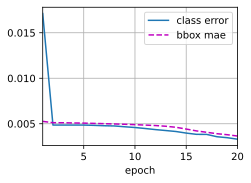

In [46]:
num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=['class error', 'bbox mae'])
net = net.to(devices)
for epoch in range(num_epochs):
    metric = d2l.Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(devices), target.to(devices)
        # anchors[1, 一张图中anchors的总数，4]
        # cls_preds[bs, 一张图中anchor的总数，num_classes + 1]
        # bbox_preds[bs, 一张图中anchor总数 * 4]
        anchors, cls_preds, bbox_preds = net(X)
        # bbox_labels[batch_size, anchor总数 * 4]
        # bbox_masks[batch_size, anchors总数，4]
        # cls_labels[batch_size, anchor总数]
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks), bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(devices)}')

- 使用跑好的模型进行测试

In [49]:
X = torchvision.io.read_image('../img/banana.jpg').unsqueeze(0).float()
img = X.squeeze(0).permute(1, 2, 0).long()  

In [ ]:
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(devices))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1) # 按照类别划分，有两个类别，重新调整维度，到[bs,类别，anchor总数]
    output = d2l.multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0][idx]

output = predict(X)

torch.Size([41, 6])

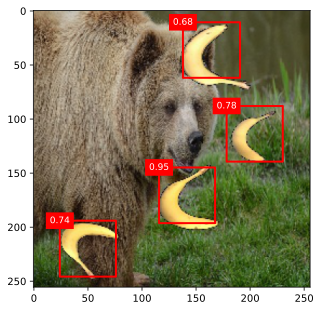

In [61]:
import matplotlib.pyplot as plt
def display(img, output, threshold):
    d2l.set_figsize((5, 5))
    fig = plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[:2]
        bbox = [row[2:] * torch.tensor((w, h, w, h), device=row.device)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'r')
display(img, output.cpu(), 0.5)